### Load `Integral` and test it right away

In [3]:
torch.setdefaulttensortype('torch.FloatTensor')

require 'image'
local lena = image.lena():mean(1):squeeze()

require 'Integral-jit'

-- compute true forward and backward results for some data
local intGold = Integral(16, 512, 512)
local params, gradParamsGold = intGold:getParameters()

local forwardGold = intGold:forward(lena)
local gradInputGold = intGold:backward(lena, forwardGold)

-- remove the old slow class
Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-jit'] = nil

-- require the new fast class
require 'Integral-c'

local intTest = Integral(16, 512, 512)
local paramsTest, gradParamsTest = intTest:getParameters()

paramsTest:copy(params)
intTest:recalculateArea()

-- compare results
local forwardTest = intTest:forward(lena)
local forwardErr = (forwardGold - forwardTest):abs():sum() / 
                   forwardTest:nElement() / torch.abs(forwardGold):mean()
print('Output mean relative error:', forwardErr * 100 .. ' %')

local gradInputTest = intTest:backward(lena, forwardGold)
local gradInputErr = (gradInputGold - gradInputTest):abs():sum() / 
                     gradInputTest:nElement() / torch.abs(gradInputGold):mean()
print('gradInput mean relative error:', gradInputErr * 100 .. ' %')
local gradParamsErr = (gradParamsGold - gradParamsTest):abs():sum() / 
                      gradParamsTest:nElement() / torch.abs(gradParamsGold):mean()
print('gradParams mean relative error:', gradParamsErr * 100 .. ' %')

assert(forwardErr    < 1e-6)
assert(gradInputErr  < 1e-6)
assert(gradParamsErr < 7e-4)

Output mean relative error:	1.5581343049562e-06 %	


gradInput mean relative error:	1.3775900353091e-06 %	
gradParams mean relative error:	0.038982911794383 %	


### Test multi-channel vs single-channel `Integral`

Output mean relative error:	34.663706309869 %	


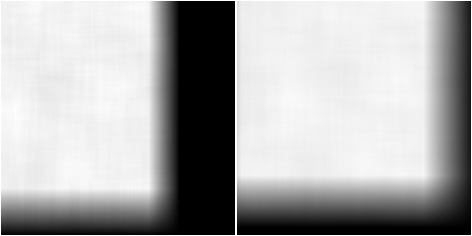

In [40]:
torch.setdefaulttensortype('torch.FloatTensor')

local nInputCh = 1
local nWindows = 1

require 'image'
torch.manualSeed(3)
local input = torch.rand(nInputCh, 234, 234)

Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
require 'Integral-jit'

-- compute true forward result for some data
local intGold = Integral(nWindows, 234, 234)
local params, gradParamsGold = intGold:getParameters()

local forwardGold = torch.Tensor(nInputCh*nWindows, 234, 234)
for i = 1,nInputCh do
    forwardGold[{{(i-1)*nWindows+1, i*nWindows}}]:copy(intGold:forward(input[i]))
end

-- remove the single-channel class
Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil

-- require the new multi-channel class
require 'Integral-jit-multi'

local intTest = Integral(nWindows, 234, 234)
for i,member in ipairs{'xMin','xMax','yMin','yMax'} do
    intTest[member] = intGold[member]
end

local forwardTest = intTest:forward(input)

-- forwardGold = forwardGold[1]
-- forwardTest = forwardTest[1]

local forwardErr = (forwardGold - forwardTest):abs():sum() / 
                   forwardTest:nElement() / torch.abs(forwardGold):mean()
print('Output mean relative error:', forwardErr * 100 .. ' %')

itorch.image{forwardGold, forwardTest}

### Measure execution times

Input: 1024x768 image

* **Forward** experiment: compute `16x1024x768` feature maps 4 times
* **Backward** experiment: do a backprop step (from the "after `Forward`" state) 4 times

#### Forward

* $0.487 \pm 0.087$ sec. (LuaJIT loop)
* $0.358 \pm 0.019$ sec. (C loop)
* $0.321 \pm 0.037$ sec. (+ precomputed `t,b,l,r`)
* $0.165 \pm 0.058$ sec. (+ parallel)
* $0.140 \pm 0.066$ sec. (+ inline `areaCoeff` multiplication)

#### Backward

* $2.660 \pm 0.252$ sec. (LuaJIT)
* $1.956 \pm 0.385$ sec. (C parallel `updGI`)
* $1.616 \pm 0.274$ sec. (+ C gradParam loop, precomputed `t,b,l,r`)
* $1.357 \pm 0.136$ sec. (+ parallelize by deltas -- 2 threads)
* $1.991 \pm 0.358$ sec. (+ parallelize by deltas -- 4 threads)
* $1.576 \pm 0.290$ sec. (+ parallelize by rows)

In [2]:
h = 768
w = 1024
nMaps = 16

In [3]:
int = Integral(16, 768, 1024)
params, gradParams = int:getParameters()

#### Forward experiment

In [13]:
img = torch.rand(h, w)
local repeats = 4
local timeRepeats = 20

local times = torch.Tensor(timeRepeats)

for timeRepeat = 1,timeRepeats do

    local timer = torch.Timer()

    for _ = 1,repeats do
        int:forward(img)
    end

    timer:stop()

    times[timeRepeat] = timer:time().real
    
    collectgarbage()
    
end

print(times:mean() .. ' +/- ' .. 2.1 * times:std() .. ' seconds')

0.14028808116913 +/- 0.065786130018442 seconds	


#### Backward experiment

In [5]:
img = torch.rand(h, w)
local repeats = 4
local timeRepeats = 15

times = torch.Tensor(timeRepeats)

int:forward(img)
int:backward(img, int.output)

for timeRepeat = 1,timeRepeats do

    local timer = torch.Timer()

    for _ = 1,repeats do
        int:backward(img, int.output)
    end

    timer:stop()

    times[timeRepeat] = timer:time().real
    
    collectgarbage()
    
end

print(times:mean() .. ' +/- ' .. 2.1 * times:std() .. ' seconds')

1.7457907358805 +/- 0.35399270740207 seconds	
